In [1]:
from helpers.pitch import draw_3d_pitch
from helpers.plotting import *
import pandas as pd 
from mplsoccer import Pitch, VerticalPitch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import sqlite3

In [2]:
player = 'Frenkie de Jong' #EPL TEST
league = 'La_Liga'
query = f'''
with raw as (
SELECT
  Minute,
  Second,
  MatchId,
  TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Length,
  Angle,
  LAG(PlayerId)
    OVER (PARTITION BY MatchId ORDER BY Minute, Second ASC) as Passed_from,
  LEAD(PlayerId)
    OVER (PARTITION BY MatchId ORDER BY Minute, Second ASC) as Passed_to
FROM
  `soccer-analytics-344915.Event_Data.{league}_2022`)

SELECT 
  raw.Minute,
  raw.Second,
  raw.MatchId,
  raw.TeamId,
  raw.PlayerId,
  players.player as Player,
  raw.X,
  raw.Y,
  raw.Type,
  raw.OutcomeType,
  qlookup.qualifier as Qualifier,
  eventlookup.Event,
  raw.PassEndX,
  raw.PassEndY,
  raw.Length,
  raw.Angle,
  players1.player as Passed_From,
  players2.player as Passed_To

FROM 
raw,

UNNEST(raw.SatisfiedEventsTypes) as EventTypes,
UNNEST(raw.Qualifiers) as Qualifiers

LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Players` as players ON raw.PlayerId = players.id
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Event_Types` as eventlookup ON EventTypes = eventlookup.Id
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Qualifiers` as qlookup ON Qualifiers = qlookup.Id

LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Players` as players1 ON raw.Passed_from= players1.id 

LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Players` as players2 ON raw.Passed_to = players2.id


LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Teams` as teams ON raw.TeamId = teams.id

WHERE 
players.player ='{player}' OR 
players1.player ='{player}' OR 
players2.player ='{player}'

'''

master = pd.read_gbq(query)

In [3]:
conn = sqlite3.connect(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\2022_data.db")
fbref = pd.read_sql('SELECT * FROM Players_Data',conn)

In [4]:
def plot_passes(ax3d,master):
    keypass = df = master[(master['Player'] == player) & (master['Type'] == 'Pass') &(master['Qualifier'] =='KeyPass') & (master['OutcomeType'] == True)].drop(['Qualifier','Event'],axis=1).drop_duplicates()
    assist = master[(master['Event']=='assist') & (master['Player'] == player)].drop('Qualifier',axis=1).drop_duplicates()
    startx = keypass['X'].tolist()
    starty = keypass['Y'].tolist()
    endx = keypass['PassEndX'].tolist()
    endy = keypass['PassEndY'].tolist()
    for i in range(len(keypass)):
        ax3d.plot([startx[i],endx[i]],[starty[i],endy[i]],[0,0],color='#E75A7C')
    
    startx = assist['X'].tolist()
    starty = assist['Y'].tolist()
    endx = assist['PassEndX'].tolist()
    endy = assist['PassEndY'].tolist()
    for i in range(len(assist)):
        ax3d.plot([startx[i],endx[i]],[starty[i],endy[i]],[0,0],color='white')
    return ax3d


In [5]:
def plot_sonar(master,ax,cmap_lst):
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
    passes =  master[(master['Player'] == player) & (master['Type'] == 'Pass')  & (master['OutcomeType'] == True)].drop(['Qualifier','Event'],axis=1).drop_duplicates().dropna()
    bins = pd.cut(passes['Angle'],bins=8)
    passes['Bins'] = [(a.left + a.right)/2 for a in bins]
    grouped = passes.groupby('Bins').agg(Mean=('Length', np.mean),Sum=('Length', np.size)).reset_index()
    grouped['scaled'] = grouped['Sum']/grouped['Sum'].mean()
    colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(grouped['scaled'])
    ax.bar(grouped['Bins'],grouped['Mean'],color=colors)
    ax.axis('off')
    return ax


In [6]:
def plot_receipts(ax,master,pitchcolor,linecolor,cmap_lst):
    received = master[(master['Passed_To'] == player) & (master['Type'] == 'Pass')  & (master['OutcomeType'] == True)].drop(['Qualifier','Event'],axis=1).drop_duplicates().dropna()
    pitch =  Pitch(pitch_type='opta',line_zorder=2,pitch_color=pitchcolor,line_color=linecolor)
    pitch.draw(ax=ax)
    bin_statistic = pitch.bin_statistic(received['PassEndX'], received['PassEndY'], statistic='count', bins=(50,50))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#22312b')
    return ax


In [7]:
def plot_graph(master,ax,player,color1,color2,textcolor):
    all_passes = master[(master['Player']==player) & (master['Type']=='Pass')].drop(['Event','Qualifier'],axis=1).drop_duplicates()
    bins = pd.cut(all_passes['Length'],bins=10)
    all_passes['Bins'] = [(a.left + a.right)/2 for a in bins]
    outcomes = all_passes.groupby(['Bins','OutcomeType'])[['OutcomeType']].size().to_frame().reset_index()
    total = outcomes.groupby('Bins').sum().reset_index()
    total['%'] = np.round(outcomes[outcomes['OutcomeType']==True][0].values/total[0].values * 100,1)
    ax.bar(total['Bins'],total[0],width=3.2,color=color1)
    ax.bar(outcomes[outcomes['OutcomeType']==True]['Bins'],outcomes[outcomes['OutcomeType']==True][0],width=1,color=color2)
    for i in range(len(total)):
        ax.text(total['Bins'].iloc[i],total[0].iloc[i]+20,f"{total['%'].iloc[i]}%",ha='center',color=textcolor)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    return ax 

In [8]:
def get_stats(fbref,player,ax):
    fbref = fbref[fbref['Player'] == player][['Passes_Made_With_Left_Foot','Passes_Made_With_Right_Foot','Pass_Completion_Percent']]
    left = round((fbref['Passes_Made_With_Left_Foot']/(fbref['Passes_Made_With_Left_Foot']+fbref['Passes_Made_With_Right_Foot']).iloc[0]* 100).iloc[0],1)
    right = round((fbref['Passes_Made_With_Right_Foot']/(fbref['Passes_Made_With_Left_Foot']+fbref['Passes_Made_With_Right_Foot']).iloc[0]* 100).iloc[0],1)
    if left>right:
        ax.text(0.3,0.5,f'{left}%',fontsize=15)
        ax.text(0.47,0.5,'Left Footed',fontsize=8)
    else:
        ax.text(0.3,0.5,f'{right}%',fontsize=15)
        ax.text(0.47,0.5,'Right Footed',fontsize=8)
    pct_s = f"{fbref['Pass_Completion_Percent'].iloc[0]}% Pass Accuracy"
    ax.text(0.3,0.35,pct_s)
    return ax 

In [19]:
def plot_passes_2d(ax,master,pitchcolor,linecolor,color1,color2):
    keypass = master[(master['Player'] == player) & (master['Type'] == 'Pass') &(master['Qualifier'] =='KeyPass') & (master['OutcomeType'] == True)].drop(['Qualifier','Event'],axis=1).drop_duplicates()
    assist = master[(master['Event']=='assist') & (master['Player'] == player)].drop('Qualifier',axis=1).drop_duplicates()
    pitch =  VerticalPitch(pitch_type='opta',line_zorder=2,half=True,pitch_color=pitchcolor,line_color=linecolor,goal_type='box',pad_top=10)
    pitch.draw(ax=ax)
    pitch.lines(keypass['X'],keypass['Y'],keypass['PassEndX'],keypass['PassEndY'],color=color1,ax=ax,lw=1.2)
    pitch.scatter(keypass['PassEndX'],keypass['PassEndY'],ax=ax,color=color1,s=20)
    pitch.lines(assist['X'],assist['Y'],assist['PassEndX'],assist['PassEndY'],color=color2,ax=ax,lw=1.2)
    pitch.scatter(assist['PassEndX'],assist['PassEndY'],ax=ax,color=color2,s=20)
    return ax

In [20]:
pitchcolor = 'green'
linecolor = 'white'

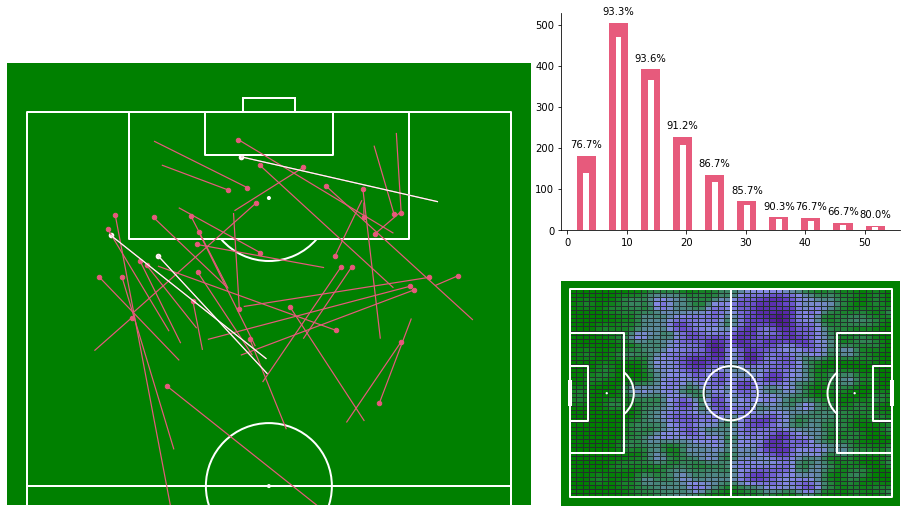

In [21]:
gs = gridspec.GridSpec(5,5)
pitchcolor='green'
fig = plt.figure()
fig.set_size_inches(16,10)
passax = fig.add_subplot(gs[:5,:3])
passax = plot_passes_2d(passax,master,pitchcolor,linecolor,'#E75A7C','white')
accuracyax = fig.add_subplot(gs[:2:,3:])
accuracyax = plot_graph(master,accuracyax,player,'#E75A7C','white','black')
cmap_lst = [pitchcolor,'#858AE3','#613DC1','#4E148C']
receiptsax = fig.add_subplot(gs[2:,3:])
receiptsax = plot_receipts(receiptsax,master,pitchcolor,linecolor,cmap_lst)
plt.subplots_adjust(hspace=0)


In [12]:
leaguename = 'La-Liga'
sca = fbref[(fbref['Nineties']>12) & (fbref['Competition_Name']==leaguename)]['Shot_Creating_Actions_per_90'].to_frame().sort_values('Shot_Creating_Actions_per_90')

0.0 0.0
0.0 0.0
0.03 0.03
0.03 0.03
0.05 0.05
0.06 0.06
0.06 0.06
0.06 0.06
0.06 0.06
0.07 0.07
0.08 0.08
0.08 0.08
0.09 0.09
0.1 0.1
0.11 0.11
0.12 0.12
0.13 0.13
0.13 0.13
0.16 0.16
0.16 0.16
0.17 0.17
0.17 0.17
0.17 0.17
0.18 0.18
0.18 0.18
0.19 0.19
0.19 0.19
0.2 0.2
0.2 0.2
0.21 0.21
0.21 0.21
0.23 0.23
0.24 0.24
0.25 0.25
0.25 0.25
0.26 0.26
0.27 0.27
0.28 0.28
0.28 0.28
0.29 0.29
0.32 0.32
0.33 0.33
0.33 0.33
0.33 0.33
0.34 0.34
0.35 0.35
0.36 0.36
0.36 0.36
0.37 0.37
0.37 0.37
0.38 0.38
0.39 0.39
0.4 0.4
0.41 0.41
0.41 0.41
0.42 0.42
0.43 0.43
0.44 0.44
0.44 0.44
0.46 0.46
0.47 0.47
0.48 0.48
0.5 0.5
0.51 0.51
0.51 0.51
0.53 0.53
0.54 0.54
0.54 0.54
0.55 0.55
0.55 0.55
0.56 0.56
0.56 0.56
0.57 0.57
0.58 0.58
0.58 0.58
0.6 0.6
0.62 0.62
0.66 0.66
0.67 0.67
0.69 0.69
0.69 0.69
0.7 0.7
0.73 0.73
0.75 0.75
0.76 0.76
0.76 0.76
0.84 0.84
0.85 0.85
0.87 0.87
0.88 0.88
0.89 0.89
0.92 0.92
0.92 0.92
0.95 0.95
0.96 0.96
0.98 0.98
0.99 0.99
0.99 0.99
1.0 1.0
1.02 1.02
1.02 1.02
1.02 1.02


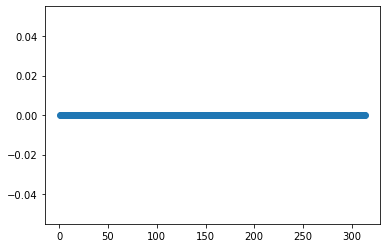

In [13]:
def get_y_coords(df):
    counter = 0
    bins = []
    current = 0
    bottom = 0
    horizontal = []
    htmp = 0 
    for idx,row in df.iterrows():
        current +=0.1
        if (counter > 8) or ((bottom-row['Shot_Creating_Actions_per_90']) < 0.01):
            current = 0
            bottom = row['Shot_Creating_Actions_per_90']
            print(bottom,row['Shot_Creating_Actions_per_90'])
            counter = 0
            htmp+=1
        bins.append(current)
        counter +=1
        horizontal.append(htmp)
    return bins,horizontal
sca['bins'],sca['h'] = get_y_coords(sca)
plt.scatter(x=sca['h'],y=sca['bins'])

In [14]:
sca['h'].value_counts()

1      1
207    1
214    1
213    1
212    1
      ..
105    1
104    1
103    1
102    1
313    1
Name: h, Length: 313, dtype: int64

In [15]:
sca

,Shot_Creating_Actions_per_90,bins,h
264,0.00,0,1
1122,0.00,0,2
259,0.03,0,3
245,0.03,0,4
261,0.05,0,5
...,...,...,...
1857,4.76,0,309
2264,5.19,0,310
2909,5.24,0,311
2060,5.56,0,312
